In [1]:
import sys
# Add the ptdraft folder path to the sys.path list
sys.path.append('..')
sys.path.insert(0, './node2vec/') # use local node2vec, modified to allow temporal walk option

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
from utils import read_graph, remove_random_edges


In [2]:
from gensim.models.callbacks import CallbackAny2Vec
class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''
    
    def __init__(self, quiet=True, print_last=False, plot=True):
        self.epoch = 0
        self.previous_running_sum = 0
        self.losses = []
        self.quiet = quiet
        self.print_last = print_last
        self.plot = plot
    
    def on_epoch_begin(self, model):
        if not self.quiet:
            print("Epoch #{} start".format(self.epoch))
    
    def on_epoch_end(self, model):
        next_running_sum = model.get_latest_training_loss()
        loss = next_running_sum - self.previous_running_sum
        if not self.quiet:
            print("Epoch #{} end -- loss = {}".format(self.epoch, loss))
        self.epoch += 1
        self.previous_running_sum = next_running_sum
        self.losses.append(loss)
        
    def on_train_end(self, model):
        if self.print_last:
            print("final loss: {}".format(self.losses[-1]))
        if self.plot:
            plt.plot(self.losses)
            plt.xlabel("epoch")
            plt.ylabel("training loss")
            plt.title("Training loss over epochs")
            plt.show()

## Gridsearch for $p$ and $q$

In [84]:
G = read_graph("../db/BTCAlphaNet.csv", temporal=False)
test_edges, test_weights = remove_random_edges(G, int(nx.number_of_edges(G)*0.2))
val_edges, val_weights = remove_random_edges(G, int(nx.number_of_edges(G)*0.125))
best_loss, best_p, best_q = np.inf, -1, -1
for p in [0.25, 0.5, 1, 2, 4]:
    for q in [0.25, 0.5, 1, 2, 4]:
        node2vec = Node2Vec(G, workers=4, p=p, q=q, temporal=False, relational_weighting=False)
        print("p = {}\t q={}".format(p, q))
        epoch_logger = EpochLogger(quiet=True, print_last=True, plot=True)
        model = node2vec.fit(sg=1, negative=0, min_count=1, compute_loss=True, callbacks=[epoch_logger], iter=1,
                     relational_weighting=False)
        
        print("Getting embeddings for train/val... ", end='')
        edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
        m = nx.number_of_edges(G)
        X_train = np.zeros((m, node2vec.dimensions))
        y_train = np.zeros((m))
        for i, edge in enumerate(G.edges):
            X_train[i] = edges_embs[tuple(map(str,edge))]
            y_train[i] = G.get_edge_data(*edge)['weight']
            
        X_val = np.zeros((len(val_edges), node2vec.dimensions))
        for i, edge in enumerate(val_edges):
            X_val[i] = edges_embs[tuple(map(str,edge))]
        y_val = np.array(val_weights)
        print("done!")
        
        print("Fitting SVR...", end='')
        reg = SVR(gamma='scale').fit(X_train, y_train)
        print("done!")
        
        y_pred = reg.predict(X_val)
        print("Root mean squared error = ", end='')
        loss = np.sqrt(mean_squared_error(y_val, y_pred))
        print(loss)
        
        if loss < best_loss:
            print("New min loss!")
            best_loss = loss
            best_p = p
            best_q = q



Computing transition probabilities:   0%|          | 0/3783 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 12/3783 [00:00<00:31, 119.86it/s]

Computing transition probabilities:   1%|          | 28/3783 [00:00<00:29, 126.76it/s]

Computing transition probabilities:   2%|▏         | 62/3783 [00:00<00:23, 155.89it/s]

Computing transition probabilities:   3%|▎         | 100/3783 [00:00<00:19, 188.85it/s]

Computing transition probabilities:   4%|▍         | 149/3783 [00:00<00:15, 230.92it/s]

Computing transition probabilities:   6%|▌         | 214/3783 [00:00<00:12, 282.34it/s]

Computing transition probabilities:   8%|▊         | 285/3783 [00:00<00:10, 344.48it/s]

Computing transition probabilities:  10%|█         | 389/3783 [00:00<00:07, 429.50it/s]

Computing transition probabilities:  12%|█▏        | 454/3783 [00:00<00:07, 446.24it/s]

Computing transition probabilities:  14%|█▎        | 514/3783 [00:01<00:07, 437.13it/s]

Computing transition probabilitie

37830
2
p = 0.5	 q=0.5


/usr/local/lib/python3.7/site-packages/gensim/models/base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


KeyboardInterrupt: 

In [65]:
best_p, best_q

NameError: name 'best_p' is not defined

## Evaluation 

In [23]:
G = read_graph("../db/OTCNet-T.csv", temporal=True)
test_edges, test_weights = remove_random_edges(G, int(nx.number_of_edges(G)*0.1))
val_edges, val_weights = remove_random_edges(G, int(nx.number_of_edges(G)*1.0/9))
#G.remove_edges_from(val_edges)

In [24]:
#test_edges, test_weights = remove_random_edges(G, int(nx.number_of_edges(G)*(1.0/9)))

Computing transition probabilities: 100%|██████████| 5881/5881 [00:00<00:00, 6541.79it/s]


58810
2
Epoch #0 start


/usr/local/lib/python3.7/site-packages/gensim/models/base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


Epoch #0 end -- loss = 0


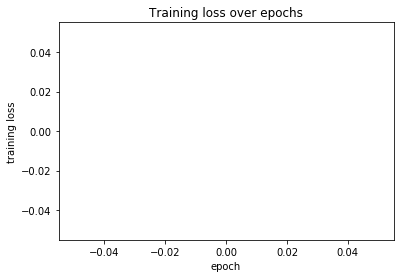

In [33]:
new_test_edges, new_test_weights = remove_random_edges(G, int(nx.number_of_edges(G)*(3.0/5)))
test_edges.extend(new_test_edges)
test_weights.extend(new_test_weights)
node2vec = Node2Vec(G, weight_key='weight', workers=4, p=1, q=1, temporal=True, relational_weighting=True,
                    trans_factor=1)
epoch_logger = EpochLogger(quiet=False, print_last=False, plot=True)
model = node2vec.fit(sg=1, negative=0, min_count=1, compute_loss=True, callbacks=[epoch_logger], iter=1,
                     relational_weighting=True)

In [34]:
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
m = nx.number_of_edges(G)
X_train = np.zeros((m, node2vec.dimensions))
y_train = np.zeros((m))
for i, edge in enumerate(G.edges):
    X_train[i] = edges_embs[tuple(map(str,edge))]
    y_train[i] = G.get_edge_data(*edge)['weight']

X_test = np.zeros((len(test_edges), node2vec.dimensions))
y_test = np.zeros((len(test_edges)))
for i, edge in enumerate(test_edges):
    X_test[i] = edges_embs[tuple(map(str,edge))]
    y_test[i] = test_weights[i]

In [35]:
reg = SVR(gamma='scale').fit(X_train, y_train)

In [36]:
from sklearn.metrics import mean_squared_error
# Make predictions using the testing set
y_pred = reg.predict(X_test)

# The mean squared error
print("Root mean squared error: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

Root mean squared error: 0.37005002227095124
